## Kredi Kartı Sahtekarlık Tespiti - Veri Ön İşleme
### Bu notebook, kredi kartı sahtekarlık tespiti projesi için veri önişleme adımlarını içermektedir.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Özel modüllerimizi import edelim
import sys
sys.path.append('..')  # Ana dizini ekleyelim

from src.utils.logger import setup_logger
from src.constants import NUMERIC_COLUMNS, CLASS_COLUMN, TIME_COLUMN, AMOUNT_COLUMN, FEATURE_COLUMNS

# Constants dosyasında olmayan değişkenleri burada tanımlayalım
TARGET = CLASS_COLUMN
NUMERICAL_FEATURES = NUMERIC_COLUMNS
CATEGORICAL_FEATURES = []  # Bu veri setinde kategorik değişken yok gibi görünüyor
ID_FEATURES = []  # ID özelliği yoksa boş liste olarak belirtelim

from src.preprocessing.feature_engineering import (
    handle_missing_values, scale_features, create_time_features,
    create_amount_features, apply_pca, create_interaction_features
)
from src.preprocessing.pipeline import FraudPreprocessor
from src.config import PREPROCESSING_CONFIG

# Logger'ı ayarlayalım
logger = setup_logger("preprocessing_notebook")

In [2]:
data_path = r'C:\Users\PC\Desktop\fraud_eye\data\raw\creditcard.csv'

df = pd.read_csv(data_path)

In [3]:
print(f"Veri seti boyutu: {df.shape}")
df.head()

Veri seti boyutu: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print("\nSütun isimleri:")
print(df.columns.tolist())


Sütun isimleri:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [5]:
print("Veri seti boyutu:", df.shape)
print("\nVeri tipi bilgileri:")
print(df.dtypes)

print("\nEksik değerler:")
print(df.isnull().sum())

print("\nSınıf dağılımı:")
print(df[TARGET].value_counts())
print(f"Normal işlemler: {df[TARGET].value_counts()[0]/len(df)*100:.4f}%")
print(f"Sahtekarlık işlemleri: {df[TARGET].value_counts()[1]/len(df)*100:.4f}%")

# Target (Class) sütununun tipini kontrol edelim
print(f"\nTarget sütun tipi: {df[TARGET].dtype}")

# Eğer TARGET sütunu string tipinde geldiyse sayısal tipe dönüştürelim
if df[TARGET].dtype == 'object':
    df[TARGET] = df[TARGET].astype(int)
    print("TARGET sütunu sayısal tipe dönüştürüldü.")

Veri seti boyutu: (284807, 31)

Veri tipi bilgileri:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Eksik değerler:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    

In [6]:
preprocessor = FraudPreprocessor(config=PREPROCESSING_CONFIG)

# Veriyi eğitim ve test setlerine ayıralım (stratify=True ile dengesiz sınıf dağılımını koruyoruz)
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET, axis=1), 
    df[TARGET], 
    test_size=0.2, 
    random_state=42, 
    stratify=df[TARGET]
)

# Eğitim setlerini tekrar birleştirelim (preprocessor hem X hem y'yi birlikte bekliyor)
train_df = X_train.copy()
train_df[TARGET] = y_train

test_df = X_test.copy()
test_df[TARGET] = y_test

print(f"Eğitim seti boyutu: {train_df.shape}")
print(f"Test seti boyutu: {test_df.shape}")

2025-05-02 17:04:19,994 | INFO | pipeline.py:31 | Initialized FraudPreprocessor


Eğitim seti boyutu: (227845, 31)
Test seti boyutu: (56962, 31)


In [7]:
# Preprocessing pipeline'ını eğitim ve test setlerine uygulayalım
processed_train_df = preprocessor.preprocess(train_df, training=True)
processed_test_df = preprocessor.preprocess(test_df, training=False)

# İşlenmiş veri setlerinin boyutlarını görelim
print(f"İşlenmiş eğitim seti boyutu: {processed_train_df.shape}")
print(f"İşlenmiş test seti boyutu: {processed_test_df.shape}")

# İşlenmiş verilerin ilk birkaç satırı
processed_train_df.head()

2025-05-02 17:04:20,185 | INFO | pipeline.py:43 | Preprocessing data (training mode)
2025-05-02 17:04:20,206 | INFO | feature_engineering.py:23 | Handling missing values with strategy: median
2025-05-02 17:04:20,222 | INFO | feature_engineering.py:44 | No missing values found in the dataset
2025-05-02 17:04:20,226 | INFO | feature_engineering.py:100 | Creating time-based features
2025-05-02 17:04:20,267 | INFO | feature_engineering.py:122 | Created time-based features: hour_of_day, day_of_week, is_weekend
2025-05-02 17:04:20,271 | INFO | feature_engineering.py:135 | Creating amount-based features
2025-05-02 17:04:20,379 | INFO | feature_engineering.py:159 | Created amount-based features
2025-05-02 17:04:20,384 | INFO | feature_engineering.py:59 | Scaling features using standard scaler
2025-05-02 17:04:20,517 | INFO | feature_engineering.py:87 | Scaled 30 features
2025-05-02 17:04:20,522 | INFO | pipeline.py:97 | Preprocessing complete. Output shape: (227845, 41)
2025-05-02 17:04:20,522

İşlenmiş eğitim seti boyutu: (227845, 41)
İşlenmiş test seti boyutu: (56962, 41)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,hour_of_day,day_of_week,is_weekend,log_amount,amount_cat_very_small,amount_cat_small,amount_cat_medium,amount_cat_large,amount_cat_very_large,amount_cat_huge
265518,1.411588,0.993379,-0.456037,-0.894052,-0.467284,1.089217,3.024383,-1.194852,0.957057,1.281376,...,20.0,1,0,2.118662,True,False,False,False,False,False
180305,0.623141,1.038507,-0.029349,-2.018302,0.175133,2.133506,2.478840,-0.001832,0.566704,0.041121,...,10.0,1,0,1.383791,True,False,False,False,False,False
42664,-1.130680,-0.506766,0.366065,0.470114,-0.700918,-0.598748,1.470411,-1.786684,-4.227592,0.000064,...,11.0,0,0,5.171052,False,False,False,True,False,False
198723,0.794699,1.166419,-0.909447,-0.493095,-1.178149,-1.010692,-0.262292,-1.153123,0.008765,-1.019866,...,12.0,1,0,1.960095,True,False,False,False,False,False
82325,-0.748102,-0.229485,-0.613041,0.076742,-2.440089,0.518711,-0.109914,0.407186,-0.095161,-0.041449,...,16.0,0,0,4.467057,False,False,True,False,False,False



Zaman özellikleri dağılımı:


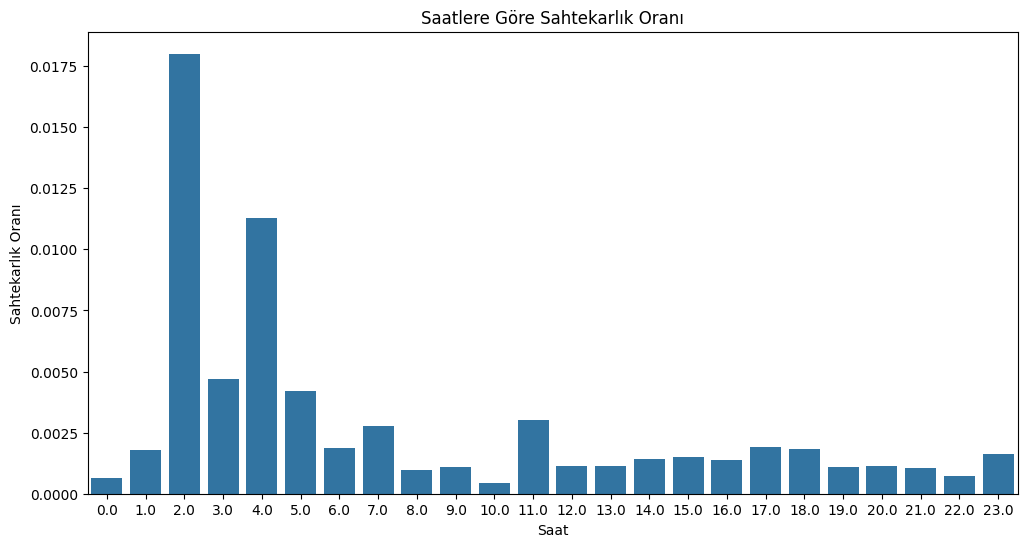


Tutar özellikleri dağılımı:


<Figure size 1200x600 with 0 Axes>

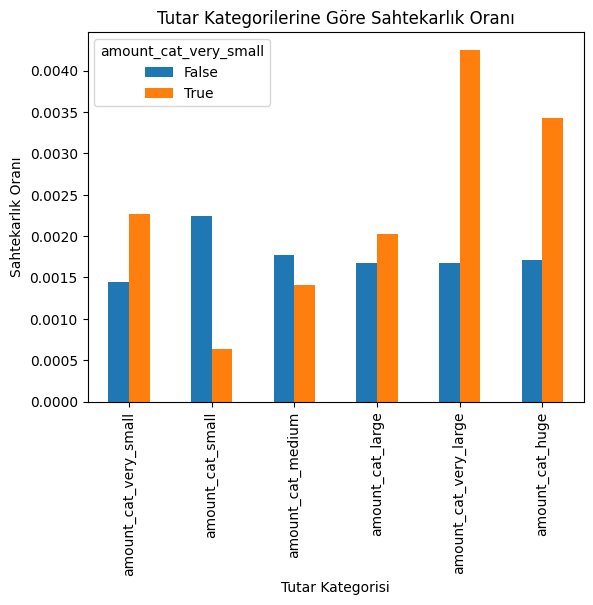

In [8]:
time_features = ['hour_of_day', 'day_of_week', 'is_weekend']
amount_features = ['log_amount', 'amount_cat_very_small', 'amount_cat_small', 
                   'amount_cat_medium', 'amount_cat_large', 'amount_cat_very_large', 'amount_cat_huge']

# Zaman özelliklerini inceleyelim (mevcut ise)
time_cols = [col for col in time_features if col in processed_train_df.columns]
if time_cols:
    print("\nZaman özellikleri dağılımı:")
    processed_train_df[time_cols].describe()
    
    # Saatlik sahtekarlık oranları
    if 'hour_of_day' in processed_train_df.columns:
        plt.figure(figsize=(12, 6))
        fraud_by_hour = processed_train_df.groupby('hour_of_day')[TARGET].mean()
        sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values)
        plt.title('Saatlere Göre Sahtekarlık Oranı')
        plt.xlabel('Saat')
        plt.ylabel('Sahtekarlık Oranı')
        plt.show()

# Tutar özellikleri
amount_cols = [col for col in amount_features if col in processed_train_df.columns]
if amount_cols:
    print("\nTutar özellikleri dağılımı:")
    processed_train_df[amount_cols].describe()
    
    # Tutar kategorilerine göre sahtekarlık oranları
    cat_cols = [col for col in amount_cols if col.startswith('amount_cat_')]
    if cat_cols:
        fraud_by_amount = pd.DataFrame()
        for col in cat_cols:
            fraud_by_amount[col] = processed_train_df.groupby(col)[TARGET].mean()
        
        plt.figure(figsize=(12, 6))
        fraud_by_amount.T.plot(kind='bar')
        plt.title('Tutar Kategorilerine Göre Sahtekarlık Oranı')
        plt.xlabel('Tutar Kategorisi')
        plt.ylabel('Sahtekarlık Oranı')
        plt.show()

2025-05-02 17:04:21,081 | INFO | pipeline.py:110 | Splitting features and target
2025-05-02 17:04:21,105 | INFO | pipeline.py:110 | Splitting features and target


Eğitim seti sınıf dağılımı: 
Class
0    227451
1       394
Name: count, dtype: int64
Eğitim setinde sahtekarlık oranı: 0.1729%

Dengeleme sonrası:
Dengelenmiş eğitim seti boyutu: (68235, 40)
Dengelenmiş eğitim seti sınıf dağılımı: 
Class
0    45490
1    22745
Name: count, dtype: int64
Dengelenmiş eğitim setinde sahtekarlık oranı: 33.3333%


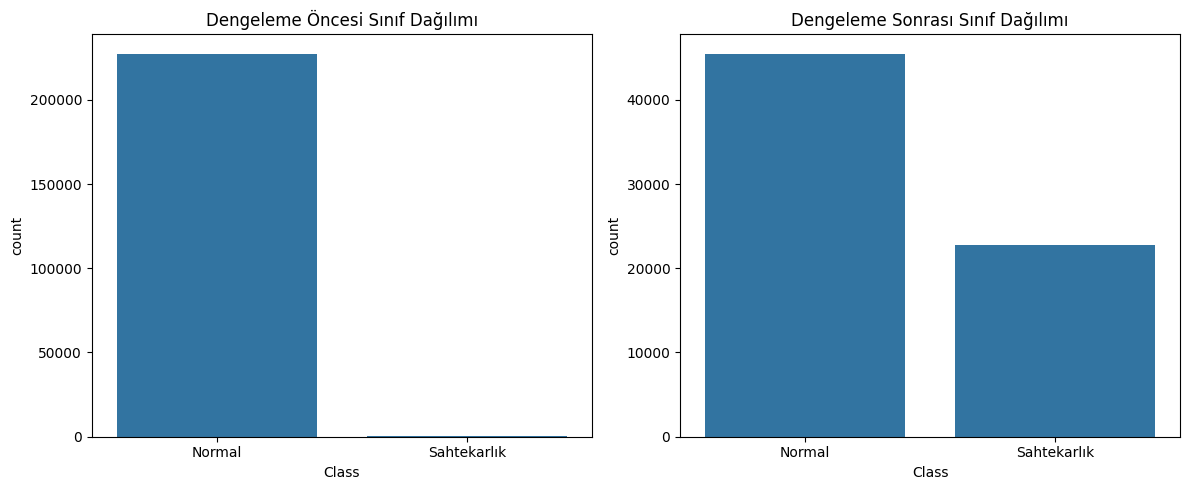

In [9]:
# Özellik ve hedef değişkenleri ayıralım
X_train_processed, y_train_processed = preprocessor.get_features_and_target(processed_train_df)
X_test_processed = preprocessor.get_features_and_target(processed_test_df, include_target=False)

print(f"Eğitim seti sınıf dağılımı: \n{y_train_processed.value_counts()}")
print(f"Eğitim setinde sahtekarlık oranı: {y_train_processed.mean()*100:.4f}%")

# Dengeleme yöntemlerini hazırlayalım
# 1. SMOTE (Over-sampling)
smote = SMOTE(sampling_strategy=0.1, random_state=42)  # %10 oranında azınlık sınıfı üretelim

# 2. Random Under Sampling (Under-sampling)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 1:2 oranı

# İki yöntemi birlikte kullanalım (önce SMOTE, sonra RUS)
# Buna "combined sampling" da denilir
combined_pipeline = ImbPipeline([
    ('smote', smote),
    ('under', rus)
])

# Dengeleme uygulayalım
X_train_balanced, y_train_balanced = combined_pipeline.fit_resample(X_train_processed, y_train_processed)

print("\nDengeleme sonrası:")
print(f"Dengelenmiş eğitim seti boyutu: {X_train_balanced.shape}")
print(f"Dengelenmiş eğitim seti sınıf dağılımı: \n{pd.Series(y_train_balanced).value_counts()}")
print(f"Dengelenmiş eğitim setinde sahtekarlık oranı: {np.mean(y_train_balanced)*100:.4f}%")

# Görselleştirelim
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train_processed)
plt.title('Dengeleme Öncesi Sınıf Dağılımı')
plt.xticks([0, 1], ['Normal', 'Sahtekarlık'])

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_balanced)
plt.title('Dengeleme Sonrası Sınıf Dağılımı')
plt.xticks([0, 1], ['Normal', 'Sahtekarlık'])

plt.tight_layout()
plt.show()

In [13]:
processed_dir = r'C:\Users\PC\Desktop\fraud_eye\data\processed'
os.makedirs(processed_dir, exist_ok=True)

# İşlenmiş eğitim ve test setlerini kaydedelim
processed_train_path = os.path.join(processed_dir, 'processed_train.csv')
processed_test_path = os.path.join(processed_dir, 'processed_test.csv')
balanced_train_path = os.path.join(processed_dir, 'balanced_train.csv')

processed_train_df.to_csv(processed_train_path, index=False)
processed_test_df.to_csv(processed_test_path, index=False)

# Dengelenmiş veriyi kaydedelim
balanced_train_df = X_train_balanced.copy()
balanced_train_df[TARGET] = y_train_balanced
balanced_train_df.to_csv(balanced_train_path, index=False)

print(f"İşlenmiş eğitim verisi kaydedildi: {processed_train_path}")
print(f"İşlenmiş test verisi kaydedildi: {processed_test_path}")
print(f"Dengelenmiş eğitim verisi kaydedildi: {balanced_train_path}")

# Önişleme pipeline'ını da kaydedelim
preprocessor.save(os.path.join('..', 'models', 'preprocessing_pipeline.pkl'))
print("Önişleme pipeline'ı kaydedildi: ../models/preprocessing_pipeline.pkl")

2025-05-02 17:14:56,025 | INFO | pipeline.py:132 | Preprocessor saved to ..\models\preprocessing_pipeline.pkl


İşlenmiş eğitim verisi kaydedildi: C:\Users\PC\Desktop\fraud_eye\data\processed\processed_train.csv
İşlenmiş test verisi kaydedildi: C:\Users\PC\Desktop\fraud_eye\data\processed\processed_test.csv
Dengelenmiş eğitim verisi kaydedildi: C:\Users\PC\Desktop\fraud_eye\data\processed\balanced_train.csv
Önişleme pipeline'ı kaydedildi: ../models/preprocessing_pipeline.pkl


In [14]:
print("Önişleme ve Dengeleme Özeti:")
print("-" * 50)
print(f"Orijinal veri seti boyutu: {df.shape}")
print(f"İşlenmiş eğitim seti boyutu: {processed_train_df.shape}")
print(f"İşlenmiş test seti boyutu: {processed_test_df.shape}")
print(f"Dengelenmiş eğitim seti boyutu: {balanced_train_df.shape}")
print("-" * 50)
print(f"Özgün özellik sayısı: {len(df.columns) - 1}")  # TARGET hariç
print(f"İşlenmiş özellik sayısı: {len(processed_train_df.columns) - 1}")  # TARGET hariç
print("-" * 50)
print(f"Orijinal sahtekarlık oranı: {df[TARGET].mean()*100:.4f}%")
print(f"Dengelenmiş sahtekarlık oranı: {balanced_train_df[TARGET].mean()*100:.4f}%")

# Preprocessor konfigürasyonu
print("\nKullanılan Preprocessor Konfigürasyonu:")
for key, value in PREPROCESSING_CONFIG.items():
    print(f"{key}: {value}")

Önişleme ve Dengeleme Özeti:
--------------------------------------------------
Orijinal veri seti boyutu: (284807, 31)
İşlenmiş eğitim seti boyutu: (227845, 41)
İşlenmiş test seti boyutu: (56962, 41)
Dengelenmiş eğitim seti boyutu: (68235, 41)
--------------------------------------------------
Özgün özellik sayısı: 30
İşlenmiş özellik sayısı: 40
--------------------------------------------------
Orijinal sahtekarlık oranı: 0.1727%
Dengelenmiş sahtekarlık oranı: 33.3333%

Kullanılan Preprocessor Konfigürasyonu:
remove_outliers: True
outlier_threshold: 3.0
scale_method: standard
handle_imbalance: True
imbalance_method: smote
feature_selection: False
n_features_to_select: 15
